In [159]:
import pandas as pd
import matplotlib.pyplot as plt

In [215]:
#Read CSC 2.1 into dataframe
#filename='/Users/kciurleo/Documents/kciurleo/AGN/unorganized/oldXmatch.csv'
filename='/Users/kciurleo/Documents/kciurleo/AGN/unorganized/CSC2.1p_OIR_SDSSspecmatch.csv'
data=pd.read_csv(filename)

/var/folders/6x/hz5y30457mqg1y9dl2fg7r5m00034d/T/ipykernel_34251/1925374468.py:4: DtypeWarning: Columns (57,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(filename)


In [139]:
#Find only sources with SDSS data
sources = data.dropna(subset=['Sep_SPEC_CSC21P'])

#Find only non-extended CSC sources
point_sources = sources.loc[sources['extent_flag']==False]

In [140]:
#Saved point sources as csv, which was used in SciServer CasJobs SQL query to get Portsmouth classifications
point_sources.to_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/point_sources.csv', index=False) 

In [167]:
#Portsmouth classifications https://salims.pages.iu.edu/agn/
portsmouth=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/lines.csv')

#Agostino classifications https://salims.pages.iu.edu/agn/
agostino=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/agostino2021_table1.csv')

In [168]:
#Get the agostino spectral ids and merge into normal agostino table
agostino_IDs=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/agostino_specIDs.csv')
agostino_full =pd.merge(agostino_IDs, agostino, left_on=['objID'], right_on=['SDSS_ObjID'], how='inner')

#Combine our point source table, portsmouth classification, and agostine classifications
combined = pd.merge(point_sources, portsmouth, left_on=['PLATE', 'MJD', 'FIBERID'],right_on=['plate', 'mjd', 'fiberID'], how='left')
classified_point_sources = pd.merge(combined, agostino_full, left_on =['specobjID'],right_on=['specobjID'],how='left')

In [169]:
#Find only Seyfert Galaxies, classified as bpt="Seyfert" for Portsmouth and sl_class1=1 for Agostino
portsmouth_s2=classified_point_sources.loc[classified_point_sources['bpt']=="Seyfert"]
agostino_s2=classified_point_sources.loc[classified_point_sources['sl_class1']==1]

#Those classified by both
inner_s2=pd.merge(agostino_s2, portsmouth_s2, how='inner')

#Those classified by either
outer_s2=pd.merge(agostino_s2, portsmouth_s2, how='outer')


In [221]:
print(f'Total observations in crossmatch: {len(data)}')
print(f'All source count: {len(sources)}, {len(data)-len(sources)} not observed with SDSS')
print(f'Point source count: {len(point_sources)}, {len(sources)-len(point_sources)} extended sources')
print()
print(f'Portsmouth Seyferts:{len(portsmouth_s2)}, {len(point_sources)-len(portsmouth_s2)} non-Seyferts')
print(f'Agostino Seyferts: {len(agostino_s2)}, {len(point_sources)-len(agostino_s2)} non-Seyferts')
print()
print(f'Portsmouth-Agostino Seyferts: {len(inner_s2)}')
print(f'Portsmouth or Agostino Seyferts: {len(outer_s2)}')
print()
print(f'Marginal likelihood Portsmouth AGN: {len(portsmouth_s2.loc[portsmouth_s2["likelihood_class"]=="MARGINAL"])}')
print(f'Marginal likelihood Agostino AGN: {len(agostino_s2.loc[agostino_s2["likelihood_class"]=="MARGINAL"])}')

Total observations in crossmatch: 387441
All source count: 17666, 369775 not observed with SDSS
Point source count: 16022, 1644 extended sources

Portsmouth Seyferts:660, 15362 non-Seyferts
Agostino Seyferts: 130, 15892 non-Seyferts

Portsmouth-Agostino Seyferts: 73
Portsmouth or Agostino Seyferts: 717

Marginal likelihood Portsmouth AGN: 72
Marginal likelihood Agostino AGN: 10


In [171]:
#What do the extra agostino seyferts look like in the portsmouth categorization?
unique_to_agostino = pd.merge(agostino_s2, inner_s2, how='left', indicator=True)
unique_to_agostino = unique_to_agostino[unique_to_agostino['_merge'] == 'left_only'].drop(columns=['_merge'])
unique_to_agostino['bpt'].unique()

array(['Composite', 'LINER', 'Star Forming'], dtype=object)

In [ ]:
#SFR cutoffs from Kewley et al. (2006)
kx=np.linspace(-4,0,1000)
kNII=0.61/(kx-0.05)+1.3
kSII=0.72/(kx-0.32)+1.30

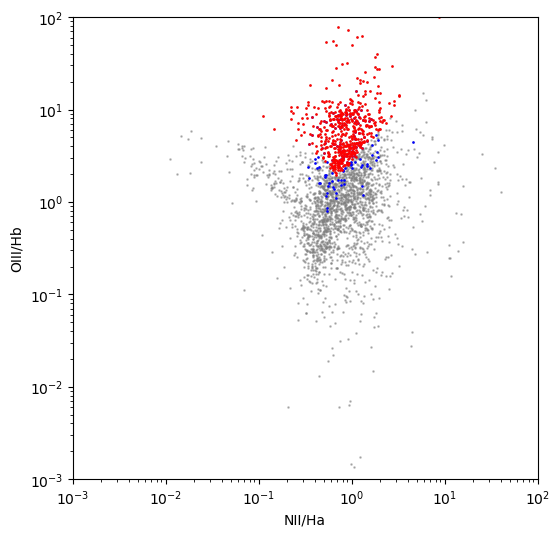

In [206]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.scatter(np.log10(classified_point_sources['Flux_NII_6583']/classified_point_sources['Flux_Ha_6562']),np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), s=3,c='gray',marker='.', alpha=0.5, label='CSC Point Sources')
plt.scatter(np.log10(portsmouth_s2['Flux_NII_6583']/portsmouth_s2['Flux_Ha_6562']),np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.', s=3, c='red', label='Portsmouth')
plt.scatter(np.log10(agostino_s2['Flux_NII_6583']/agostino_s2['Flux_Ha_6562']),np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.', s=3, c='blue', label='Agostino')
plt.plot(kx, kNII, color='black', style='dashed',label='Maximum Starburst')

plt.xlabel("log([NII]λ6583/Hα)", size=18)
plt.ylabel("log([OIII]λ5006/Hβ)", size=18)
plt.xlim(.001,100)
plt.ylim(.001,100)
plt.legend(loc='upper left', fontsize=12)

plt.show()

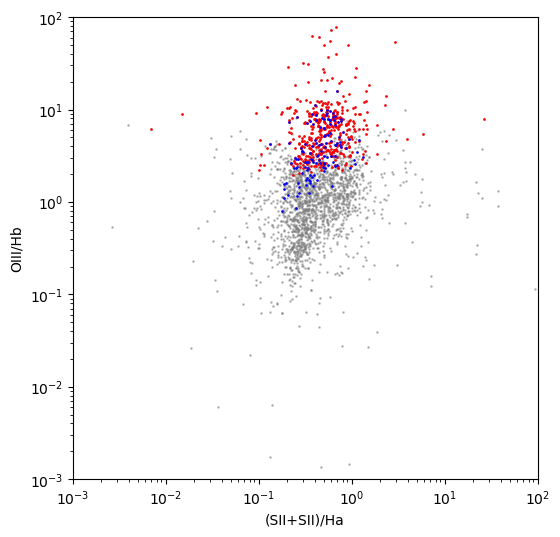

In [209]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.scatter(np.log10((classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'])/classified_point_sources['Flux_Ha_6562']),np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), marker='.', s=3,color='gray', alpha=0.5, label='CSC Point Sources')
plt.scatter(np.log10((portsmouth_s2['Flux_SII_6730']+portsmouth_s2['Flux_SII_6716'])/portsmouth_s2['Flux_Ha_6562']),np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.',s=3, c='red', label='Portsmouth')
plt.scatter(np.log10((agostino_s2['Flux_SII_6730']+agostino_s2['Flux_SII_6716'])/agostino_s2['Flux_Ha_6562']),np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.',s=3, c='blue', label='Agostino')
plt.plot(kx, kSII, color='black', style='dashed',label='Maximum Starburst')

plt.xlabel("log(([SII]λ6716 + [SII]λ6730)/Hα)", size=18)
plt.ylabel("log([OIII]λ5006/Hβ)", size=18)
plt.xlim(.001,100)
plt.ylim(.001,100)
plt.legend(loc='upper left', fontsize=12)

plt.show()